# Gold Price Prediction with Logistic Regression

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')
import seaborn as sns
import matplotlib.colors as clrs
import talib as ta
from statsmodels.tsa.stattools import adfuller
import yfinance as yf
import datetime
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

C:\Users\asee\AppData\Local\Temp\ipykernel_3412\2591833038.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [2]:
#set ticker symbol and start/end dates
ticker = 'GLD'
start_date = datetime.datetime.now() - datetime.timedelta(days=10080)
end_date = datetime.date.today()

In [3]:
#pull data from yfinance
df = yf.download(ticker, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


In [4]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-11-18,44.430000,44.490002,44.070000,44.380001,44.380001,5992000
2004-11-19,44.490002,44.919998,44.470001,44.779999,44.779999,11655300
2004-11-22,44.750000,44.970001,44.740002,44.950001,44.950001,11996000
2004-11-23,44.880001,44.919998,44.720001,44.750000,44.750000,3169200
2004-11-24,44.930000,45.049999,44.790001,45.049999,45.049999,6105100


In [5]:
#create a column 'future returns' with the calculation of percentage change
df['future_returns'] = df['Adj Close'].pct_change().shift(-1)

#create the signal column
df['signal'] = np.where(df['future_returns'] > 0, 1, 0)

df.head()

,Open,High,Low,Close,Adj Close,Volume,future_returns,signal
Date,,,,,,,,
2004-11-18,44.430000,44.490002,44.070000,44.380001,44.380001,5992000,0.009013,1
2004-11-19,44.490002,44.919998,44.470001,44.779999,44.779999,11655300,0.003796,1
2004-11-22,44.750000,44.970001,44.740002,44.950001,44.950001,11996000,-0.004449,0
2004-11-23,44.880001,44.919998,44.720001,44.750000,44.750000,3169200,0.006704,1
2004-11-24,44.930000,45.049999,44.790001,45.049999,45.049999,6105100,0.005327,1


In [6]:
#create a column 'pct_change' with the daily change
df['pct_change'] = df['Adj Close'].pct_change()

#create a column 'pct_change_week' with the 5 day percentage change
df['pct_change_week'] = df['Adj Close'].pct_change(5)

#create a column 'pct_change_month' with the monthly percentage change
df['pct_change_month'] = df['Adj Close'].pct_change(20)

In [7]:
#create RSI column
df['rsi'] = ta.RSI(df['Adj Close'].values, timeperiod=14)

#create ADX column
df['adx'] = ta.ADX(df['High'], df['Low'], df['Adj Close'], timeperiod=14)

#create MACD column
df['macd'], df['macdsignal'], df['macdhist'] = ta.MACD(df['Adj Close'], fastperiod=12, slowperiod=26, 
                                                       signalperiod = 9)

#create MFI column
df['mfi'] = ta.MFI(df['High'], df['Low'], df['Adj Close'], df['Volume'], timeperiod=14)

#create stoch column
df['slowk'], df['slowd'] = ta.STOCH(df['High'], df['Low'], df['Adj Close'], fastk_period=5, slowk_period=3,
                                   slowk_matype=0, slowd_period=3, slowd_matype=0)

#create stoch fast column
df['fastk'], df['fastd'] = ta.STOCHF(df['High'], df['Low'], df['Adj Close'], fastk_period=5, fastd_period=3,
                                   fastd_matype=0)

#create willr column
df['willr'] = ta.WILLR(df['High'], df['Low'], df['Close'], timeperiod=14)

In [8]:
#create 5 day MA
df['sma5'] = df['Adj Close'].rolling(window=5).mean()

#create 5 day correlation
df['corr5'] = df['Adj Close'].rolling(window=5).corr(df['sma5'])

#create 20 day MA
df['sma20'] = df['Adj Close'].rolling(window=20).mean()

#create 20 day correlation
df['corr20'] = df['Adj Close'].rolling(window=20).corr(df['sma20'])

#create 50 day MA
df['sma50'] = df['Adj Close'].rolling(window=50).mean()

#create 5 day correlation
df['corr50'] = df['Adj Close'].rolling(window=50).corr(df['sma50'])

In [9]:
#create 5 day volatility
df['volatility5'] = df.rolling(5, min_periods=5)['pct_change'].std()*100

#create 20 day volatility
df['volatility20'] = df.rolling(20, min_periods=20)['pct_change'].std()*100

#create 50 day volatility
df['volatility50'] = df.rolling(50, min_periods=50)['pct_change'].std()*100

In [10]:
df.shape

(4641, 31)

In [11]:
df.dropna(inplace=True)

In [12]:
#create target and features
y = df[['signal']].copy()

X = df[['Volume', 'pct_change', 'pct_change_week', 'pct_change_month', 'rsi', 'adx', 'macd', 'mfi', 
        'macdsignal', 'mfi', 'slowk', 'slowd', 'fastk', 'fastd', 'willr', 'sma5', 'corr5', 'sma20', 
        'corr20', 'sma50', 'corr50', 'volatility5', 'volatility20', 'volatility50']].copy()

In [13]:
def stationary(series):
    """Function to check if the series is stationary or not.
    """

    result = adfuller(series)
    if(result[1] < 0.05):
        return 'stationary'
    else:
        return 'not stationary'

In [14]:
# Check for stationarity
for col in X.columns:
    if stationary(df[col]) == 'not stationary':
        print('%s is not stationary. Dropping it.' % col)
        X.drop(columns=[col], axis=1, inplace=True)
    else:
        print('%s is stationary.' % col)

Volume is stationary.
pct_change is stationary.
pct_change_week is stationary.
pct_change_month is stationary.
rsi is stationary.
adx is stationary.
macd is stationary.
mfi is stationary.
macdsignal is stationary.
mfi is stationary.
slowk is stationary.
slowd is stationary.
fastk is stationary.
fastd is stationary.
willr is stationary.
sma5 is not stationary. Dropping it.
corr5 is stationary.
sma20 is not stationary. Dropping it.
corr20 is stationary.
sma50 is not stationary. Dropping it.
corr50 is stationary.
volatility5 is stationary.
volatility20 is stationary.
volatility50 is stationary.


In [15]:
def get_pair_above_threshold(X, threshold):
    """Function to return the pairs with correlation above threshold.
    """
    # Calculate the correlation matrix
    correl = X.corr()

    # Unstack the matrix
    correl = correl.abs().unstack()

    # Recurring & redundant pair
    pairs_to_drop = set()
    cols = X.corr().columns
    for i in range(0, X.corr().shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))

    # Drop the recurring & redundant pair
    correl = correl.drop(labels=pairs_to_drop).sort_values(ascending=False)

    return correl[correl > threshold].index

In [16]:
print(get_pair_above_threshold(X, 0.8))

MultiIndex([(           'slowk',        'fastd'),
            (            'macd',   'macdsignal'),
            (           'slowd',        'fastd'),
            (           'slowk',        'slowd'),
            (    'volatility20', 'volatility50'),
            (             'rsi',        'willr'),
            ('pct_change_month',         'macd'),
            ('pct_change_month',          'rsi'),
            ( 'pct_change_week',        'fastd'),
            ( 'pct_change_week',        'slowk'),
            (           'slowk',        'fastk'),
            (           'fastk',        'fastd'),
            (             'rsi',          'mfi'),
            (             'rsi',          'mfi')],
           )


In [17]:
#drop highly correlated columns
X = X.drop(columns=['volatility20', 'mfi', 'willr', 'macdsignal', 'fastd', 'slowk', 'pct_change_month'])

In [18]:
X.shape

(4542, 13)

In [19]:
# Obtain the features and target for the `train_data` and `test_data` without shuffling
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.80, shuffle=False)

In [20]:
# Print the dimensions of the variables
print(f"The shape of the X variable is {X.shape}.")
print(f"The shape of the y variable is {y.shape}. \n")
print(f"The shape of the X_train variable is {X_train.shape}.")
print(f"The shape of the y_train variable is {y_train.shape}.\n")
print(f"The shape of the X_test variable is {X_test.shape}.")
print(f"The shape of the y_test variable is {y_test.shape}.\n")

The shape of the X variable is (4542, 13).
The shape of the y variable is (4542, 1). 

The shape of the X_train variable is (3633, 13).
The shape of the y_train variable is (3633, 1).

The shape of the X_test variable is (909, 13).
The shape of the y_test variable is (909, 1).



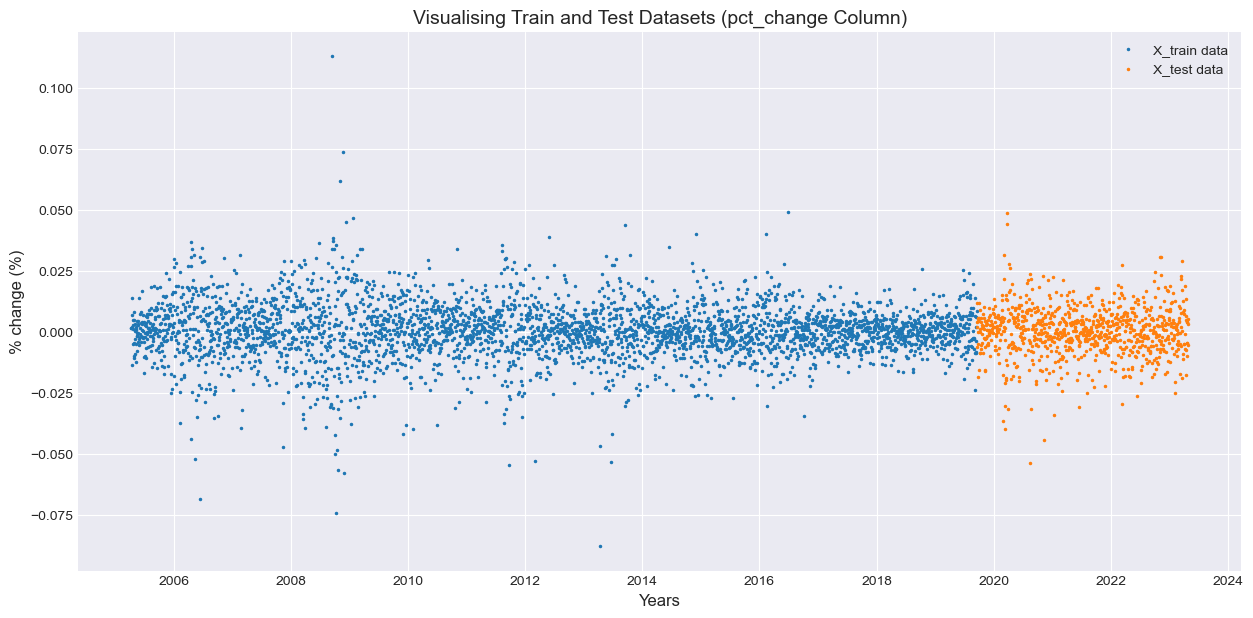

In [21]:
# Plot the data
plt.figure(figsize=(15, 7))

plt.plot(X_train['pct_change'], linestyle='None',
         marker='.', markersize=3.0, label='X_train data')
plt.plot(X_test['pct_change'], linestyle='None',
         marker='.', markersize=3.0, label='X_test data')

# Set the title and axis label
plt.title("Visualising Train and Test Datasets (pct_change Column)", fontsize=14)
plt.xlabel('Years', fontsize=12)
plt.ylabel('% change (%)', fontsize=12)

# Display the plot
plt.legend()
plt.show()

In [22]:
# Create the machine learning model
lr_model = LogisticRegression()

In [23]:
hyperparameters = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

In [24]:
grid_search = GridSearchCV(lr_model, hyperparameters, cv=5)

In [25]:
lr_model = grid_search.fit(X_train, y_train['signal'])

C:\Users\asee\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\asee\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\asee\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\asee\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\asee\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\asee\Anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was re

In [26]:
print("Best hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best hyperparameters:  {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}
Best score:  0.5260116483075092


In [27]:
# Get a sample day of data from X_test
unseen_data_single_day = X_test.head(1)

# Preview the data
unseen_data_single_day

,Volume,pct_change,pct_change_week,rsi,adx,macd,slowd,fastk,corr5,corr20,corr50,volatility5,volatility50
Date,,,,,,,,,,,,,
2019-09-17,7010200,0.001981,0.01013,50.776047,18.884414,0.387925,24.428879,50.658033,0.268736,-0.111636,0.854701,0.637325,0.972697


In [28]:
# Use the model and predict the values for the test data
y_pred = lr_model.predict(X_test)

# Display the first five predictions
print("The first five predicted values", y_pred[:5])

The first five predicted values [1 1 1 1 1]


In [29]:
y_test

,signal
Date,
2019-09-17,0
2019-09-18,1
2019-09-19,1
2019-09-20,1
2019-09-23,1
...,...
2023-04-20,0
2023-04-21,1
2023-04-24,1


In [30]:
y_test_signal = y_test['signal']

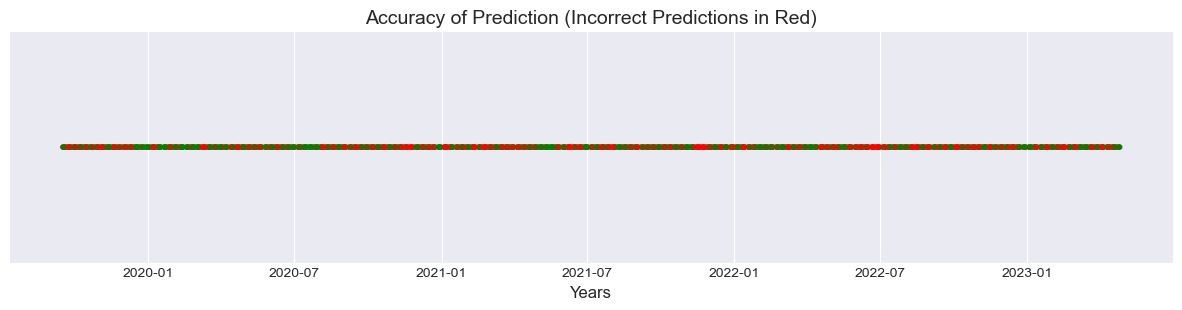

The accuracy is 53.69%.


In [31]:
# Define the accuracy data

accuracy_data = (y_pred == y_test_signal)

# Accuracy percentage
accuracy_percentage = round(100 * accuracy_data.sum()/len(accuracy_data), 2)

# Plot the accuracy data
plt.figure(figsize=(15, 3))

# Colour mapping for the correct and incorrect predictions
cmap = clrs.ListedColormap(['green', 'red'])

plt.yticks([])
plt.scatter(x=y_test.index, y=[1]*len(y_test),
            c=(accuracy_data != True).astype(float), marker='.', cmap=cmap)

# Set the title and axis label
plt.title("Accuracy of Prediction (Incorrect Predictions in Red)", fontsize=14)
plt.xlabel('Years', fontsize=12)

# Display the results
plt.show()
print(f"The accuracy is {accuracy_percentage}%.")

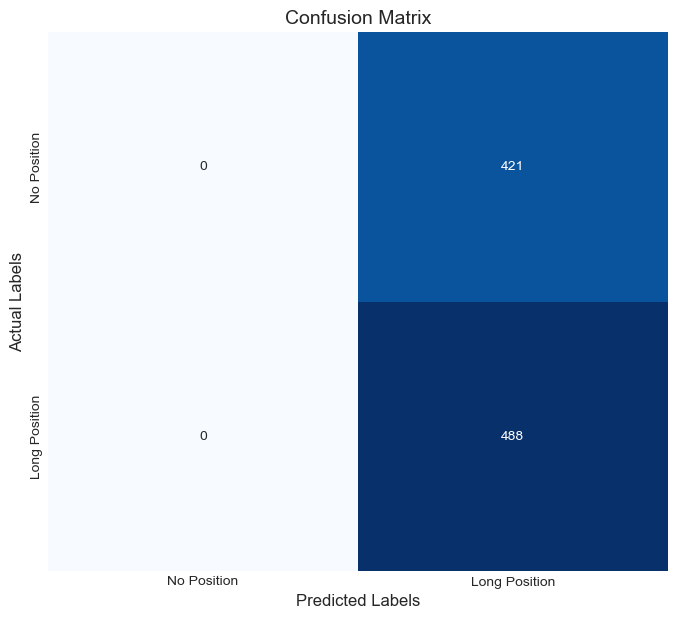

In [32]:
# Define the confusion matrix
confusion_matrix_data = confusion_matrix(y_test, y_pred)

# Plot the data
fig, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(confusion_matrix_data, fmt="d",
            cmap='Blues', cbar=False, annot=True, ax=ax)

# Set the axes labels and the title
ax.set_xlabel('Predicted Labels', fontsize=12)
ax.set_ylabel('Actual Labels', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14)
ax.xaxis.set_ticklabels(['No Position', 'Long Position'])
ax.yaxis.set_ticklabels(['No Position', 'Long Position'])

# Display the plot
plt.show()

In [33]:
# Classification report
classification_report_data = classification_report(y_test, y_pred)

# Print the classification report
print(classification_report_data)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       421
           1       0.54      1.00      0.70       488

    accuracy                           0.54       909
   macro avg       0.27      0.50      0.35       909
weighted avg       0.29      0.54      0.38       909



C:\Users\asee\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asee\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\asee\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
#create dataframe for strategy backtest
strategy_data = pd.DataFrame(y_pred, index=y_test.index, columns=['signal'])
strategy_data['close'] = df['Adj Close']

The return is 23.35%.


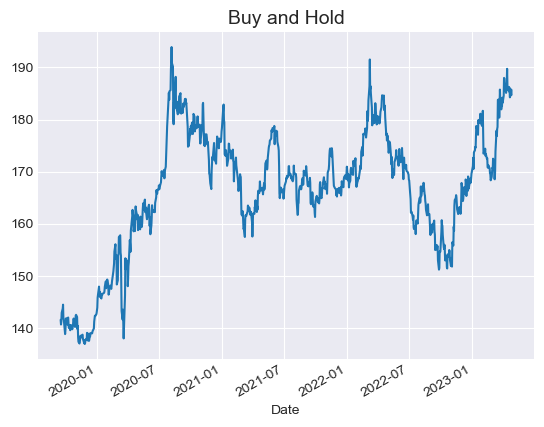

In [35]:
plt.title('Buy and Hold', fontsize=14)
strategy_data['close'].plot()
buyandhold = (1 - strategy_data['close'][0]/strategy_data['close'][-1])*100
print("The return is {0:.2f}%.".format(buyandhold))

In [36]:
# Calculate the percentage change
strategy_data['pct_change'] = strategy_data['close'].pct_change()

# Calculate the strategy returns
strategy_data['strategy_returns'] = strategy_data['signal'].shift(1) * strategy_data['pct_change']

# Drop the missing values
strategy_data.dropna(inplace=True)

strategy_data.head()

,signal,close,pct_change,strategy_returns
Date,,,,
2019-09-18,1,140.710007,-0.006285,-0.006285
2019-09-19,1,141.279999,0.004051,0.004051
2019-09-20,1,142.949997,0.011820,0.011820
2019-09-23,1,143.750000,0.005596,0.005596
2019-09-24,1,144.509995,0.005287,0.005287


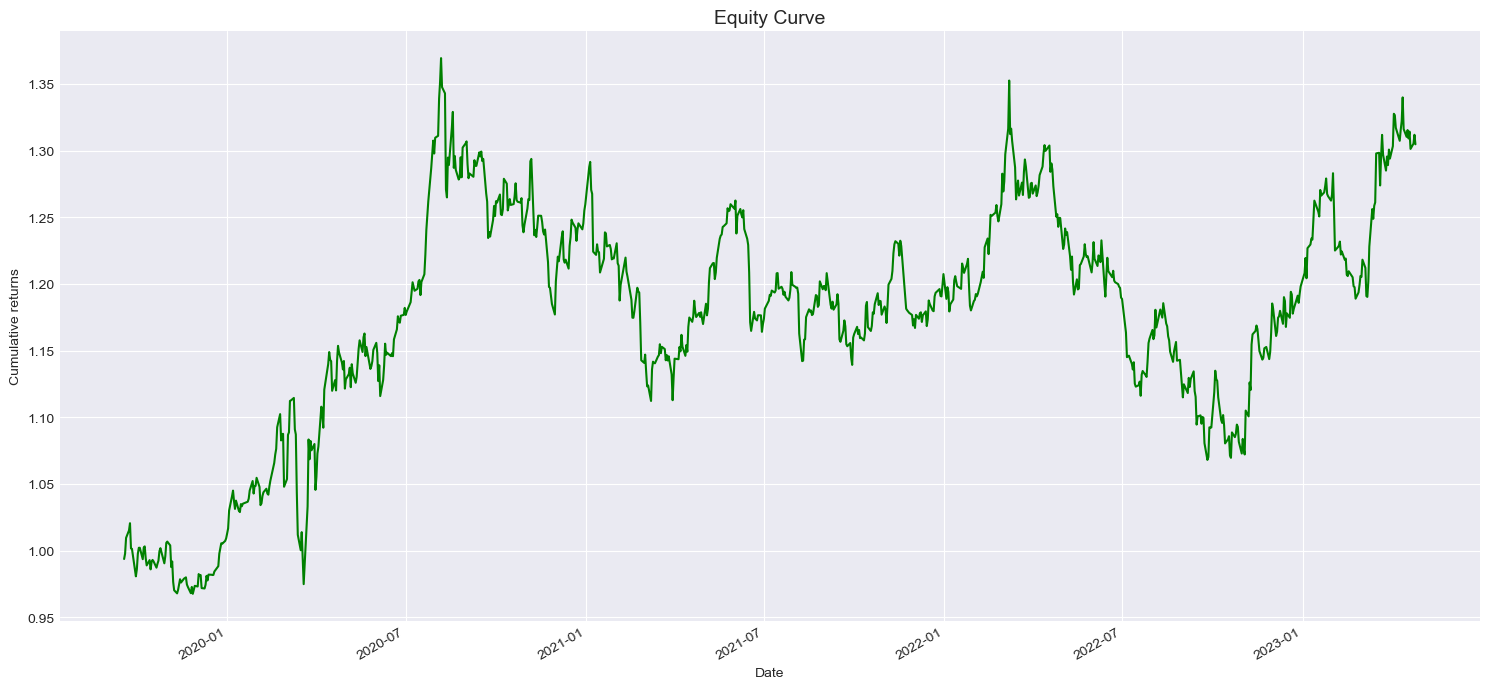

The cumulative return is 30.47%.


In [37]:
# Calculate the cumulative returns
strategy_data['cumulative_returns'] = (1+strategy_data['strategy_returns']).cumprod()

# ---------------------Equity Curve---------------------
# Plot cumulative strategy returns
strategy_data['cumulative_returns'].plot(figsize=(15, 7), color='green')
plt.title('Equity Curve', fontsize=14)
plt.ylabel('Cumulative returns')
plt.tight_layout()
plt.show()

cumulative_returns = (strategy_data['cumulative_returns'][-1] - 1)*100
print("The cumulative return is {0:.2f}%.".format(cumulative_returns))

In [38]:
# Calculate the annualised returns
annualised_return = ((strategy_data['cumulative_returns'][-1]) **
                    (252/strategy_data.shape[0]) - 1) * 100
print("The annualised return is {0:.2f}%.".format(annualised_return))

The annualised return is 7.66%.


In [42]:
# Calculate the annualised volatility
annualised_volatility = strategy_data['strategy_returns'].std()*np.sqrt(
    252) * 100
print("The annualised volatility is {0:.2f}%.".format(annualised_volatility))

The annualised volatility is 15.89%.


The maximum drawdown is -22.00%.


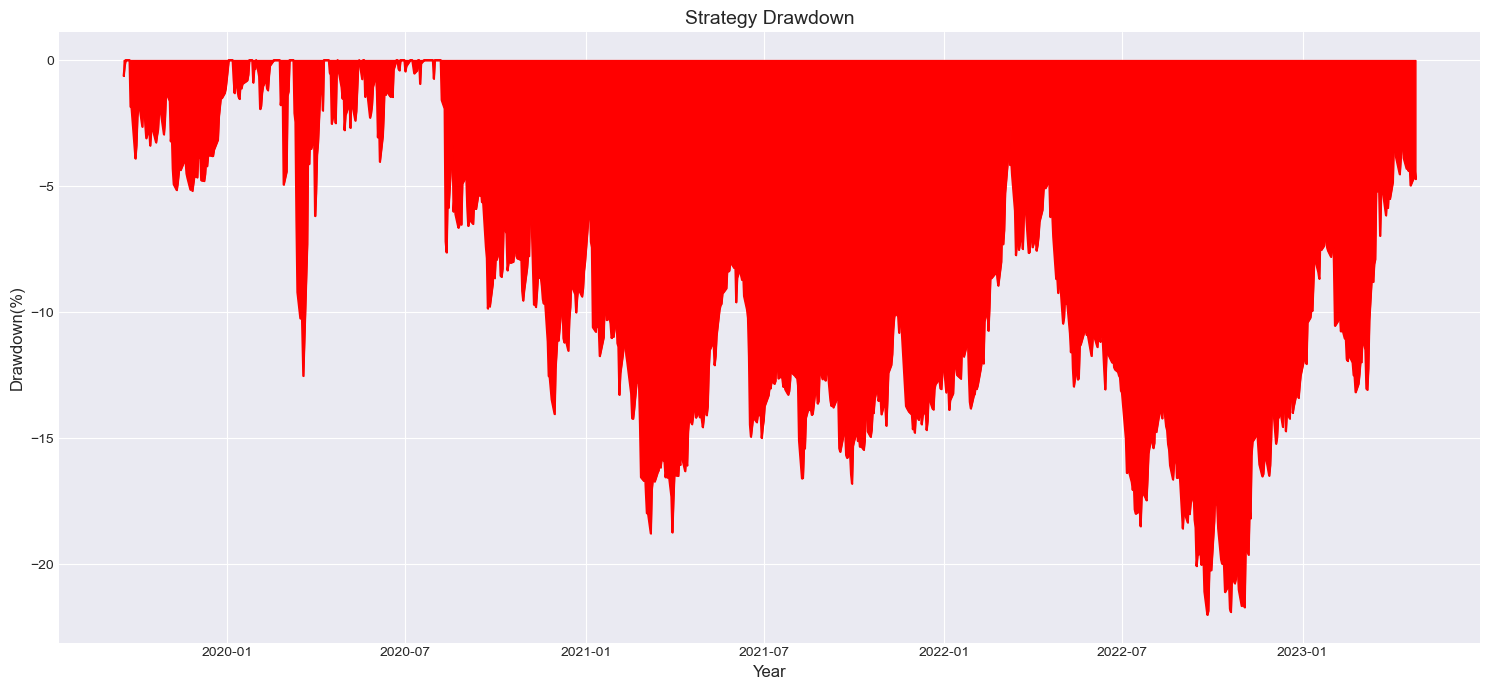

In [40]:
# Calculate the running maximum
running_max = np.maximum.accumulate(
    strategy_data['cumulative_returns'].dropna())
# Ensure the value never drops below 1
running_max[running_max < 1] = 1
# Calculate the percentage drawdown
drawdown = ((strategy_data['cumulative_returns'])/running_max - 1) * 100

# Calculate the maximum drawdown
max_dd = drawdown.min()
print("The maximum drawdown is {0:.2f}%.".format(max_dd))

# ---------------------DD plot---------------------
fig = plt.figure(figsize=(15, 7))

# Plot max drawdown
plt.plot(drawdown, color='red')
# Fill in-between the drawdown
plt.fill_between(drawdown.index, drawdown.values, color='red')
plt.title('Strategy Drawdown', fontsize=14)
plt.ylabel('Drawdown(%)', fontsize=12)
plt.xlabel('Year', fontsize=12)

plt.tight_layout()
plt.show()

In [41]:
# Calculate the Sharpe ratio
sharpe_ratio = round(strategy_data['strategy_returns'].mean() /
                     strategy_data['strategy_returns'].std() * np.sqrt(252), 2)
print("The Sharpe ratio is {0:.2f}.".format(sharpe_ratio))

The Sharpe ratio is 0.54.
